In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [2]:
import os
from unsloth import FastVisionModel
import torch
from datasets import load_dataset
from transformers import TextStreamer
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
# Load the model
model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3-4b-pt-unsloth-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)
# Configure fine-tuning parameters
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

==((====))==  Unsloth 2025.7.8: Fast Gemma3 patching. Transformers: 4.53.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


In [4]:
# Load and prepare the dataset

# dataset = load_dataset("07kamal03/cheque_dataset_bank", split = "train") # Viết thêm code thủ công để load nếu để trên máy
# instruction = "You are an OCR expert in bank. Extract the information from this bank cheque."

# dataset = load_dataset("unsloth/LaTeX_OCR", split = "train")
# instruction = "Write the LaTeX representation for this image."

dataset = load_dataset("ademax/ocr_scan_vi_01", split = "train")
instruction = "You are an expert in Vietnamese text OCR. Extract information from images containing Vietnamese text."

In [5]:
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1270x49>,
 'text': '31/12/2022 là 16.697,647 tỷ đồng/22. 855,035 tỷ đồng (đạt 73,06% kế hoạch'}

In [6]:
def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["text"]}]},
    ]
    return {"messages": conversation}

converted_dataset = [convert_to_conversation(sample) for sample in dataset]

print(converted_dataset[0])

{'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'You are an expert in Vietnamese text OCR. Extract information from images containing Vietnamese text.'}, {'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1270x49 at 0x7FD298B51750>}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': '31/12/2022 là 16.697,647 tỷ đồng/22. 855,035 tỷ đồng (đạt 73,06% kế hoạch'}]}]}



Before training:



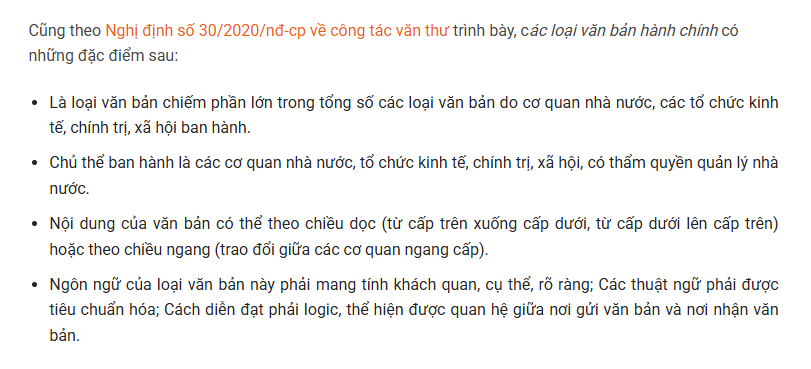


Predict:  
ഒരു
<start_of_image>എ
<start_of_image>എ
<start_of_image>ആ
ആ
ആ
ആ
<start_of_image><start_of_image>ആ

You are an expert in Vietnamese text OCR. Extract information from images containing Vietnamese text. Cookbook: Recipes

<start_of_image>ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ

You are an expert in Vietnamese text OCR. Extract information from images containing Vietnamese text.

ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ
ആ

You are an expert in


In [7]:
from unsloth import get_chat_template
processor = get_chat_template(
    processor,
    "gemma-3"
)

# Test before training
print("\nBefore training:\n")

FastVisionModel.for_inference(model)

from IPython.display import display
from PIL import Image
image = Image.open("/content/Untitled.png")
display(image)

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

text_streamer = TextStreamer(processor, skip_prompt=True)
print("\nPredict:  ")
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

In [8]:
# Configure the trainer
FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = True,

        # use reentrant checkpointing
        gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,              # max gradient norm based on QLoRA paper
        warmup_ratio = 0.03,
        max_steps = 50,
        #num_train_epochs = 2,          # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_seq_length = 2048,
    )
)

# Train the model
trainer_stats = trainer.train()

Unsloth: Switching to float32 training since model cannot work with float16


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 11,003 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,6.156900
2,5.730300
3,5.425500
4,4.721700
5,4.196300
6,3.469100
7,2.432600
8,2.254600
9,1.518000
10,1.547100



After training:



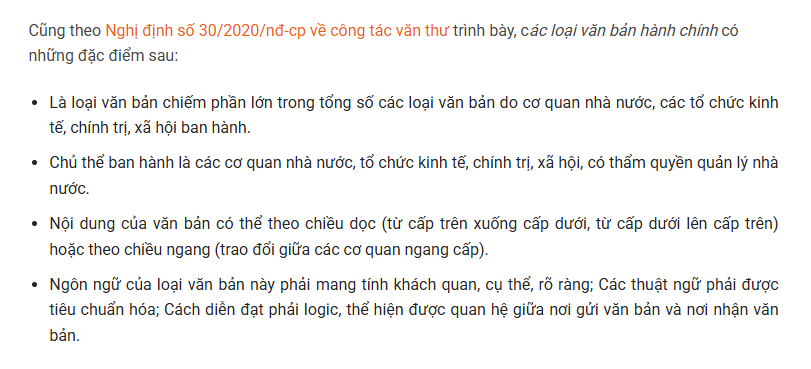


Predict:
Cũng theo Nghị định số 30/2020/nđ-cp về công tác văn thư chính, các loại văn bản hành chính có những đặc điểm sau:
* Là loại văn bản chiếm phần lớn trong tổng số các loại văn bản do cơ quan nhà nước, tổ chức kinh tế, chính trị, xã hội ban hành.
* Chủ thể ban hành là các cơ quan nhà nước, tổ chức kinh tế, chính trị, xã hội, tổ thẩm quyền quản lý nhà nước.
* Nội dung của văn bản có thể theo chiều dọc (trừ cấp xuống cấp dưới, từ cấp dưới lên cấp trên) hoặc theo chiều ngang (trao đổi giữa các cơ quan ngang cấp).
* Nguồn cửu của văn bản này phải mang tính khách quan, cụ thể, rõ ràng; Các thuật ngữ được tiêu chuẩn hóa; Cách diễn đạt logic, thể hiện được quá giới văn bản và nơi nhân văn bản.<end_of_turn>


In [12]:
# Test after training
print("\nAfter training:\n")

FastVisionModel.for_inference(model)  # Enable for inference!

from IPython.display import display
from PIL import Image
image = Image.open("/content/Untitled.png")
display(image)

instruction = "You are an expert in Vietnamese text OCR. Extract information from images containing Vietnamese text."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
print("\nPredict:")
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 10000,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

In [ ]:
# Save and upload the model
model.save_pretrained("lora_model")
processor.save_pretrained("lora_model")

model.save_pretrained_merged("model_save/unsloth/gemma-3-4b-pt", processor,)

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

In [ ]:
# Save the model and processor
model.save_pretrained("lora_model")
processor.save_pretrained("lora_model")

# Save merged model (optional, for deploying the model without LoRA)
model.save_pretrained_merged("model_save/gemma-3-4b-pt-unsloth-bnb-4bit", processor,)